In [1]:
import pandas as pd
from fbprophet import Prophet
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/xiaomiaoright/TimeSeriesProjects/master/Dataset/Miles_Traveled.csv')

In [3]:
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [5]:
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      588 non-null    datetime64[ns]
 1   y       588 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.3 KB


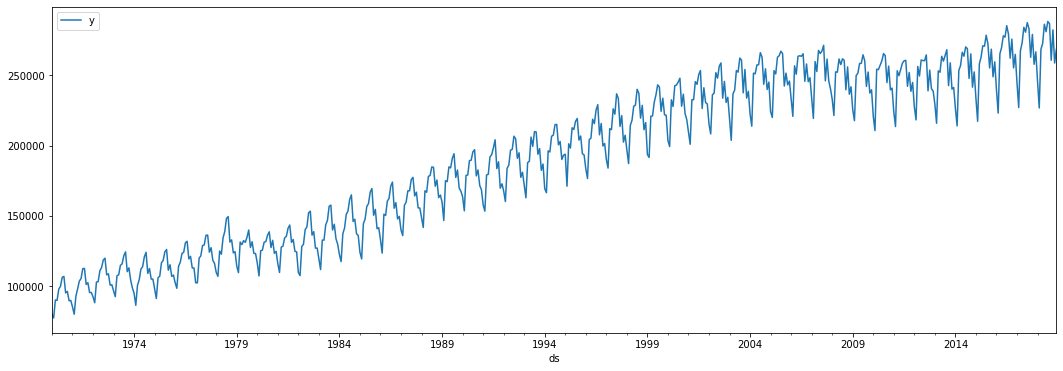

In [7]:
df.plot(x='ds',y='y',figsize=(18,6))

In [8]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [9]:
df.shape

(588, 2)

# Train test split

In [29]:
test = df.iloc[-12:]
train = df.iloc[:-12]

In [31]:
test

,ds,y
576,2018-01-01,245695.0
577,2018-02-01,226660.0
578,2018-03-01,268480.0
579,2018-04-01,272475.0
580,2018-05-01,286164.0
581,2018-06-01,280877.0
582,2018-07-01,288145.0
583,2018-08-01,286608.0
584,2018-09-01,260595.0
585,2018-10-01,282174.0


## Create Prophet model

In [12]:
model = Prophet()
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## create future dataframe for prediction

In [13]:
future = model.make_future_dataframe(24, freq='MS')
forecast = model.predict(future)

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
595,2019-08-01,265084.094077,276016.165386,287467.125699,264460.902932,265720.835785,16617.804881,16617.804881,16617.804881,16617.804881,16617.804881,16617.804881,0.0,0.0,0.0,281701.898959
596,2019-09-01,265226.209413,257402.013371,269504.884296,264533.153901,265933.431706,-1584.781347,-1584.781347,-1584.781347,-1584.781347,-1584.781347,-1584.781347,0.0,0.0,0.0,263641.428067
597,2019-10-01,265363.740384,264687.667199,276511.000545,264594.206709,266144.540279,5104.634149,5104.634149,5104.634149,5104.634149,5104.634149,5104.634149,0.0,0.0,0.0,270468.374533
598,2019-11-01,265505.855720,251871.701461,263198.285491,264680.379775,266337.079198,-8287.007693,-8287.007693,-8287.007693,-8287.007693,-8287.007693,-8287.007693,0.0,0.0,0.0,257218.848027
599,2019-12-01,265643.386690,252650.485716,264649.687630,264786.559576,266554.952253,-7066.815183,-7066.815183,-7066.815183,-7066.815183,-7066.815183,-7066.815183,0.0,0.0,0.0,258576.571507


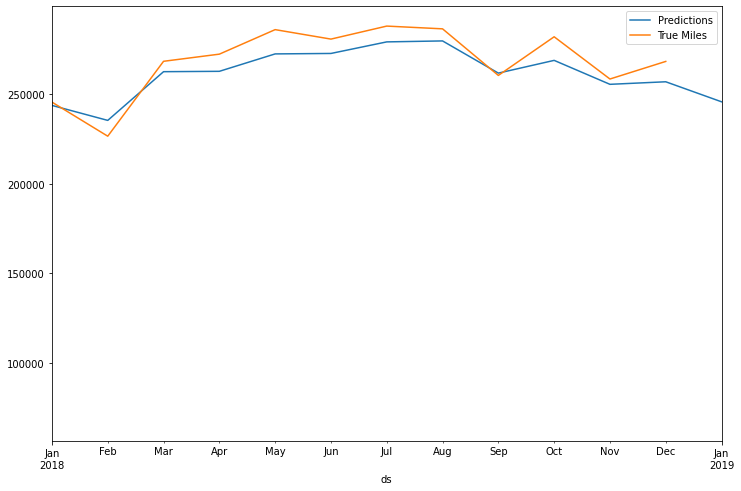

In [32]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'))

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
predictions = forecast.iloc[-12:]

In [35]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
588,2019-01-01,264112.208553,240175.344114,251556.300432,263892.362775,264414.195027,-18249.215278,-18249.215278,-18249.215278,-18249.215278,-18249.215278,-18249.215278,0.0,0.0,0.0,245862.993276
589,2019-02-01,264254.323889,231963.815094,243205.340426,263979.395318,264615.271072,-26745.042368,-26745.042368,-26745.042368,-26745.042368,-26745.042368,-26745.042368,0.0,0.0,0.0,237509.281521
590,2019-03-01,264382.686128,258559.994161,269571.411152,264086.287738,264785.854638,-398.346471,-398.346471,-398.346471,-398.346471,-398.346471,-398.346471,0.0,0.0,0.0,263984.339657
591,2019-04-01,264524.801464,258080.911649,270160.018607,264172.701521,264959.244198,-269.457961,-269.457961,-269.457961,-269.457961,-269.457961,-269.457961,0.0,0.0,0.0,264255.343504
592,2019-05-01,264662.332435,268282.469741,279380.982038,264248.525950,265153.826756,9334.358803,9334.358803,9334.358803,9334.358803,9334.358803,9334.358803,0.0,0.0,0.0,273996.691238
593,2019-06-01,264804.447771,268624.001637,280618.021799,264311.220969,265334.987198,9950.279696,9950.279696,9950.279696,9950.279696,9950.279696,9950.279696,0.0,0.0,0.0,274754.727466
594,2019-07-01,264941.978741,275778.345937,286929.510043,264390.792108,265519.844829,16202.881145,16202.881145,16202.881145,16202.881145,16202.881145,16202.881145,0.0,0.0,0.0,281144.859887
595,2019-08-01,265084.094077,276016.165386,287467.125699,264460.902932,265720.835785,16617.804881,16617.804881,16617.804881,16617.804881,16617.804881,16617.804881,0.0,0.0,0.0,281701.898959
596,2019-09-01,265226.209413,257402.013371,269504.884296,264533.153901,265933.431706,-1584.781347,-1584.781347,-1584.781347,-1584.781347,-1584.781347,-1584.781347,0.0,0.0,0.0,263641.428067
597,2019-10-01,265363.740384,264687.667199,276511.000545,264594.206709,266144.540279,5104.634149,5104.634149,5104.634149,5104.634149,5104.634149,5104.634149,0.0,0.0,0.0,270468.374533


In [37]:
mse = mean_squared_error(predictions['yhat'], test['y'])
mse

59087002.78351128

In [39]:
import numpy as np

rmse = np.sqrt(mse)
rmse

7686.807060380225

In [40]:
test['y'].mean()

268739.6666666667

In [41]:
predictions['yhat'].mean()

264426.27980336355

## Cross Validation in Prophet
Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In [42]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [43]:
df.shape

(588, 2)

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

In [44]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [45]:
# Initial 5 years training
initial = str(5*365) + ' days'
# Fold every 5 years
period = str(5*365) + ' days'
# Forecast 1 year 
horizon = str(365) + ' days'

In [46]:
df_cv = cross_validation(model, horizon=horizon, period=period, initial=initial)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


In [47]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.087306,106977.725966,109898.944845,102445.0,1976-12-11
1,1977-02-01,102996.111502,101646.497033,104386.668947,102416.0,1976-12-11
2,1977-03-01,118973.317944,117532.768912,120429.961303,119960.0,1976-12-11
3,1977-04-01,120612.923539,119189.345251,122124.971625,121513.0,1976-12-11
4,1977-05-01,127883.031663,126316.041512,129236.014843,128884.0,1976-12-11


In [48]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
103,2017-08-01,273614.230765,267853.925720,279246.324364,283184.0,2016-12-01
104,2017-09-01,255737.189562,249958.774336,261283.108313,262673.0,2016-12-01
105,2017-10-01,262845.616157,257076.256344,268425.368496,278937.0,2016-12-01
106,2017-11-01,249500.895087,243958.316469,255298.234943,257712.0,2016-12-01
107,2017-12-01,250750.668713,244891.245979,256594.121717,266535.0,2016-12-01


In [49]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,52 days,2.402227e+07,4901.251892,4506.384371,0.027631,0.023593,0.4
1,53 days,2.150811e+07,4637.683407,4238.662732,0.024863,0.023593,0.4
2,54 days,1.807689e+07,4251.692535,3708.943275,0.019933,0.022278,0.5
3,55 days,2.298205e+07,4793.960154,4236.275244,0.023042,0.023593,0.4
4,57 days,2.078937e+07,4559.535784,3972.087270,0.021317,0.022278,0.5
...,...,...,...,...,...,...,...
94,360 days,1.814608e+07,4259.821515,3750.359483,0.019596,0.019565,0.5
95,361 days,1.726110e+07,4154.647536,3473.037339,0.018212,0.018957,0.5
96,362 days,3.173990e+07,5633.817508,4404.300729,0.022034,0.024793,0.4
97,364 days,2.986513e+07,5464.900040,4229.869860,0.021378,0.021629,0.5


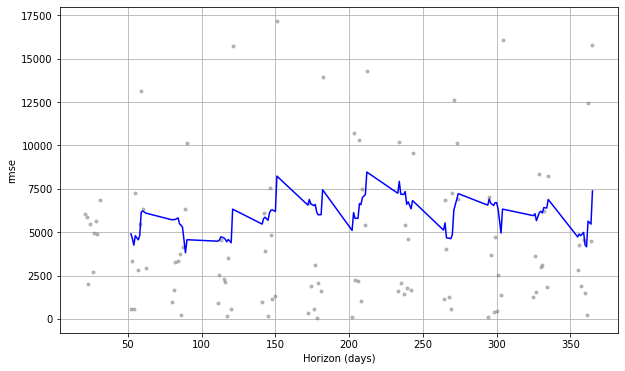

In [50]:
plot_cross_validation_metric(df_cv, metric='rmse');

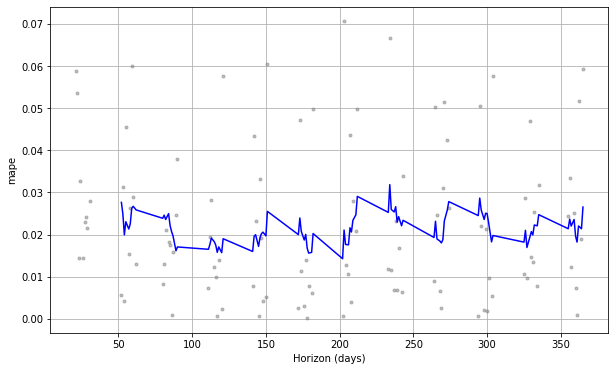

In [51]:
plot_cross_validation_metric(df_cv, metric='mape');# MAPE is Mean Absolute Percentage Error